# Модель для прогнозирования банковских срочных депозитов

<a id='1-bullet'></a>

## Этап 1. Подготовка среды и библиотек

<a id='2-bullet'></a>

Установка библиотек

In [1]:
import os

req = 'requirements.txt'
if os.path.exists(req):
    %pip install -qr requirements.txt
else:
    %pip install -qU scikit-learn numpy pandas matplotlib seaborn phik jinja2 joblib category_encoders

Note: you may need to restart the kernel to use updated packages.


Импорт библиотек

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)

---

<a id='3-bullet'></a>

In [3]:
RANDOM_STATE = 42

---

<a id='4-bullet'></a>

Загрузка датасета

In [4]:
train = pd.read_csv('dataset/train.csv', sep=',')
test = pd.read_csv('dataset/test.csv', sep=',')

## Этап 2. Первичный анализ данных

<a id='5-bullet'></a>

Анализ данных пользователей и их вовлеченности

In [5]:
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


---

In [7]:
train = train.drop(columns=['id', 'poutcome'])
test = test.drop(columns=['poutcome'])

---

<a id='6-bullet'></a>

Разделение признаков по группам

In [8]:
target = 'y'

nums = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

ohe_enc_cats = [cat for cat in cats if cat not in ['job', 'month']]
target_enc_cats = [cat for cat in cats if cat not in ohe_enc_cats]

---

<a id='7-bullet'></a>

Понижение размерности pandas датасета

In [9]:
downcast='integer'
for col in nums:
    train[col] = pd.to_numeric(train[col], downcast=downcast)
    test[col] = pd.to_numeric(test[col], downcast=downcast)

---

Анализ целевой переменной


In [10]:
y_desc = train[target].describe()

y_desc

count    750000.000000
mean          0.120651
std           0.325721
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: y, dtype: float64

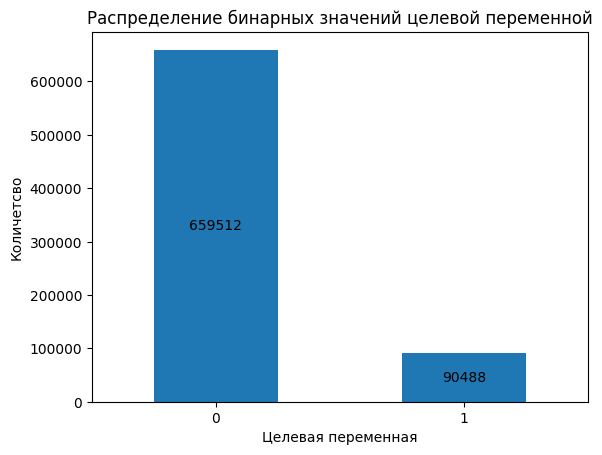

In [11]:
y_counts = train[target].value_counts()

ax = y_counts.plot(
    kind='bar',
    title='Распределение бинарных значений целевой переменной',
    xlabel='Целевая переменная',
    ylabel='Количетсво',
    rot=0
)

ax.bar_label(ax.containers[0], label_type='center')

plt.show()

In [12]:
print(f'Клиенты без срочных депозитов: {y_counts[0] / y_desc['count'] * 100:.0f}%')
print(f'Клиенты со срочными депозитами: {y_counts[1] / y_desc['count'] * 100:.0f}%')

Клиенты без срочных депозитов: 88%
Клиенты со срочными депозитами: 12%


---

In [13]:
print('Число явных дубликатов train:', train.duplicated().sum())

train = train.drop_duplicates()

Число явных дубликатов train: 1


---

In [14]:
df_eda = train.copy()

---

In [15]:
def check_cat_features(df, cats):
    data = []
    for col in cats:
        data.append({
            'Признак': col,
            'Уникальные значения': df[col].unique(),
            'Кол-во': df[col].nunique(),
        })
    
    return pd.DataFrame(data)

check_cat_features(df_eda, cats)

,Признак,Уникальные значения,Кол-во
0,job,"[technician, blue-collar, student, admin., man...",12
1,marital,"[married, single, divorced]",3
2,education,"[secondary, primary, tertiary, unknown]",4
3,default,"[no, yes]",2
4,housing,"[no, yes]",2
5,loan,"[no, yes]",2
6,contact,"[cellular, unknown, telephone]",3
7,month,"[aug, jun, may, feb, apr, nov, jul, jan, oct, ...",12


In [16]:
super_matches = [
    ('job', 'education'),
    ('month', 'marital')
]

In [17]:
new_cat_cols = []

for col1, col2 in super_matches:
    new_col = f"{col1}_{col2}"
    new_cat_cols.append(new_col)
    
    df_eda[new_col] = df_eda[col1] + '_' + df_eda[col2]

In [18]:
upd_cats = cats + new_cat_cols

In [19]:
check_cat_features(df_eda, upd_cats)

,Признак,Уникальные значения,Кол-во
0,job,"[technician, blue-collar, student, admin., man...",12
1,marital,"[married, single, divorced]",3
2,education,"[secondary, primary, tertiary, unknown]",4
3,default,"[no, yes]",2
4,housing,"[no, yes]",2
5,loan,"[no, yes]",2
6,contact,"[cellular, unknown, telephone]",3
7,month,"[aug, jun, may, feb, apr, nov, jul, jan, oct, ...",12
8,job_education,"[technician_secondary, blue-collar_secondary, ...",48
9,month_marital,"[aug_married, jun_married, may_married, may_si...",36


---

In [20]:
df_eda[nums].describe()

,age,balance,day,duration,campaign,pdays,previous
count,749999.000000,749999.000000,749999.000000,749999.000000,749999.000000,749999.000000,749999.000000
mean,40.926407,1204.069892,16.117207,256.229283,2.577005,22.412298,0.298544
std,10.098830,2836.097827,8.250838,272.555817,2.718514,77.319130,1.335927
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000


In [21]:
def create_boxplot(df, col=None, ax=None):
    data = df if col is None else df[col]
    
    if ax is None:
        _, ax = plt.subplots(figsize=(14, 8))
        standalone = True
    else:
        standalone = False
        
    sns.boxplot(data=data, ax=ax)
    
    title = 'Размах значений признака'
    if col is not None:
        title += f': {col}'
    
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=30)
    
    if standalone:
        return plt.show()
    
    return ax

In [22]:
discrete = ['day', 'campaign']

def get_df_without_discrete(df, discrete):
    for col in discrete:
        if col in df.columns:
            df = df.drop(columns=col)
            
    return df

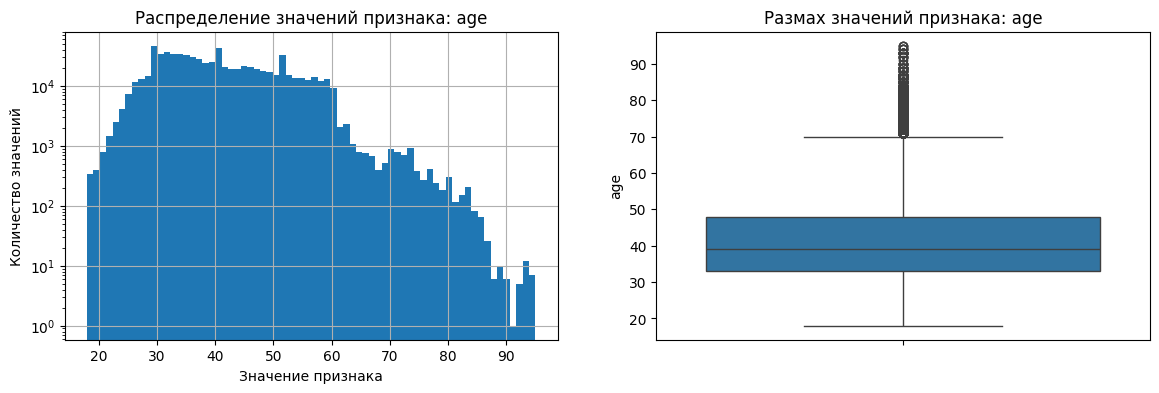

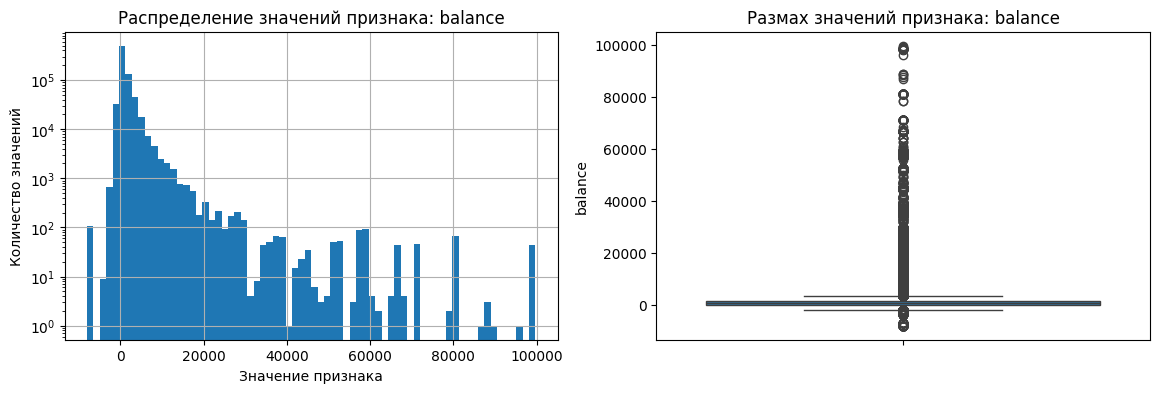

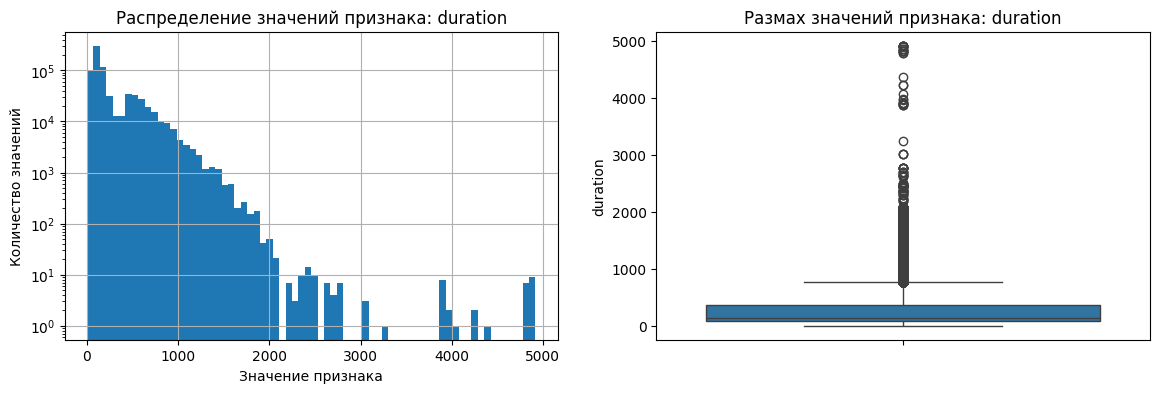

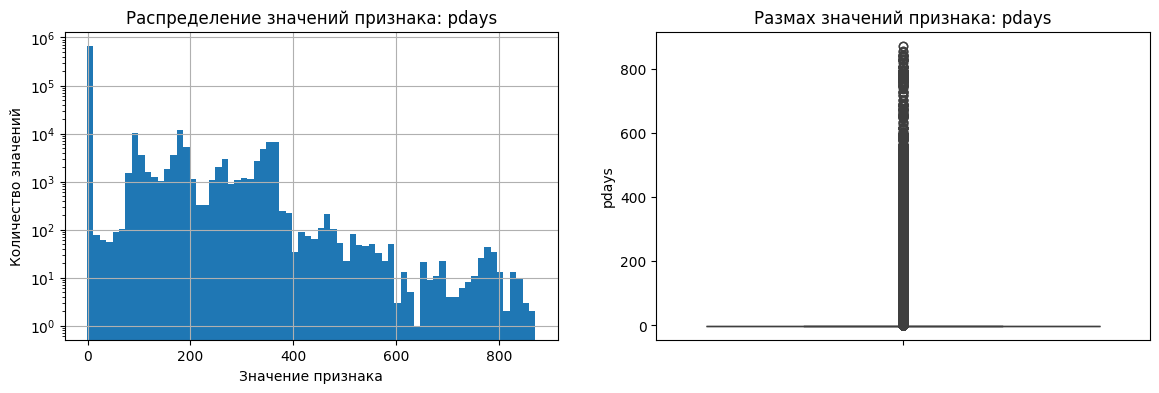

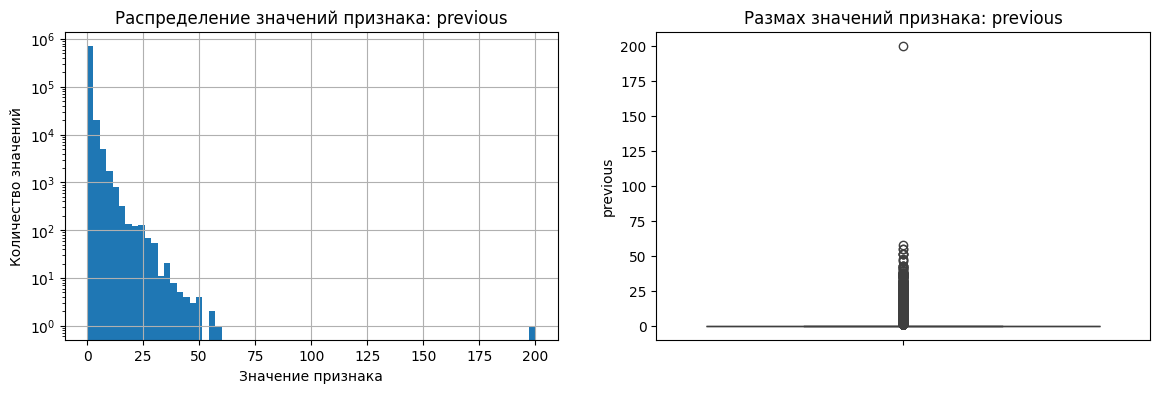

In [23]:
def get_emission_analysis(df):
    for col in df.columns:
        _, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

        hist = axes[0]
        df[col].plot(
            kind='hist',
            bins=70,
            grid=True,
            ax=hist
        )
        
        hist.set_title(f'Распределение значений признака: {col}')
        hist.set_xlabel('Значение признака')
        hist.set_ylabel('Количество значений')
        hist.set_yscale('log')

        create_boxplot(df, col, axes[1])

        plt.show()
        
        plt.close()

interval_df = get_df_without_discrete(df_eda[nums], discrete)
get_emission_analysis(interval_df)

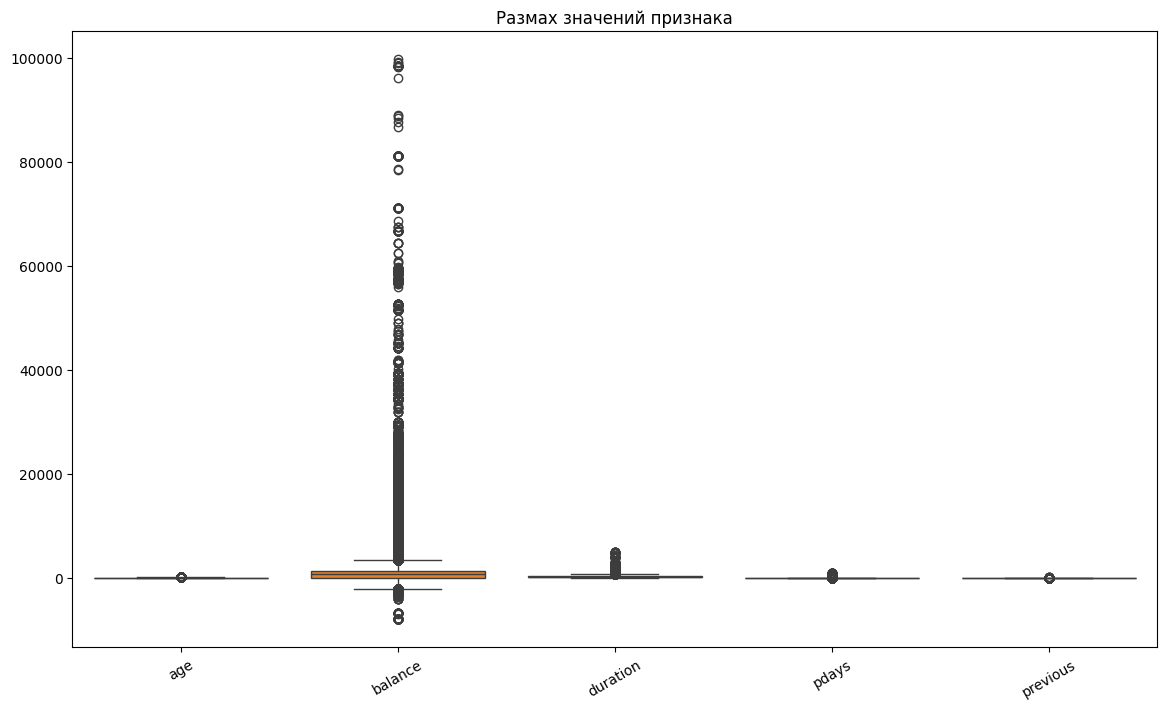

In [24]:
create_boxplot(interval_df)

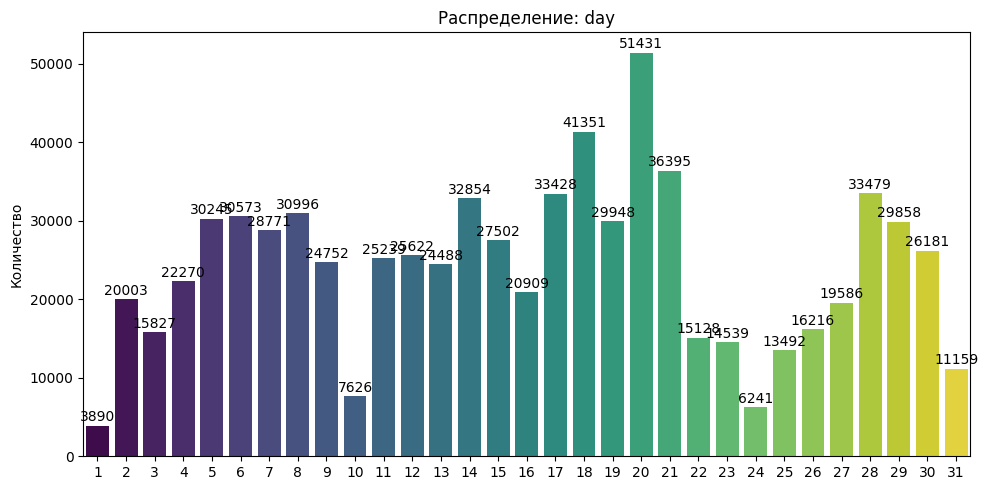

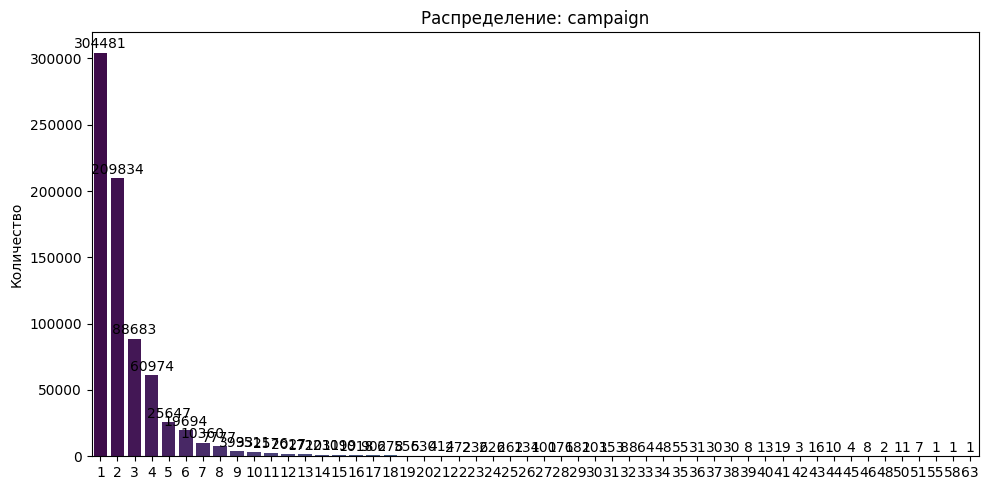

In [25]:
for col in discrete:
    if col in df_eda.columns:
        plt.figure(figsize=(10, 5))
        
        ax = sns.countplot(
            x=col,
            data=df_eda,
            hue=col,
            legend=False,
            palette='viridis'
        )
        
        plt.title(f'Распределение: {col}')
        plt.xlabel('') # в title данная информация уже есть
        plt.ylabel('Количество')

        for container in ax.containers:
            ax.bar_label(container, label_type='edge', padding=1)

        plt.tight_layout()
        plt.show()
        
        plt.close()
        

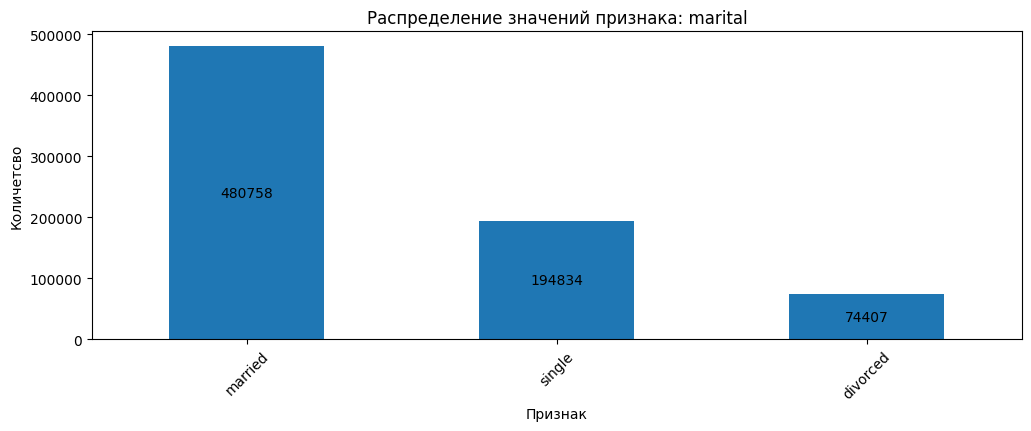

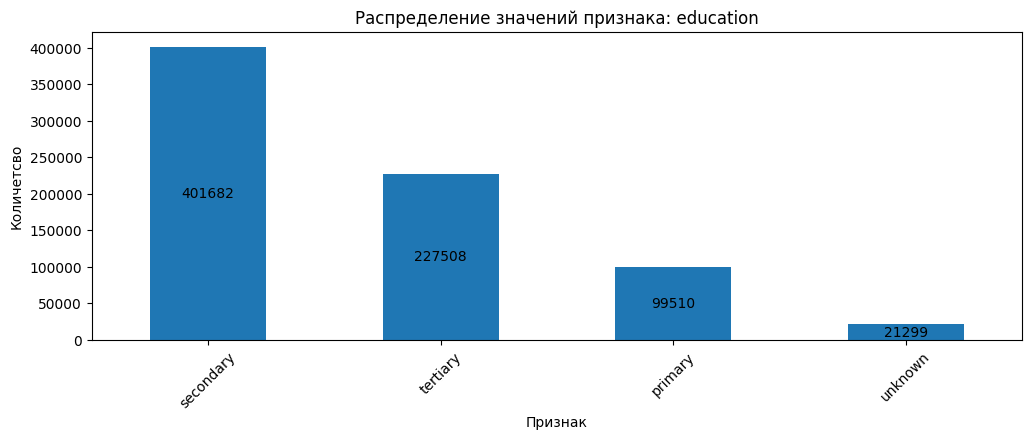

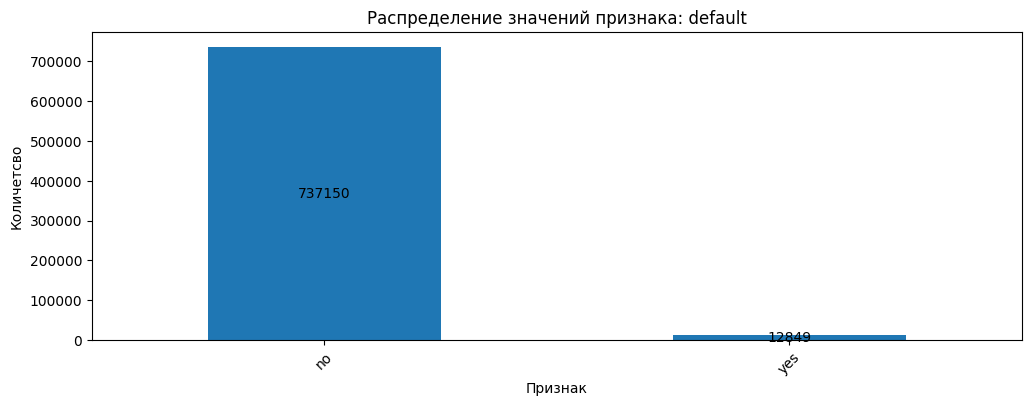

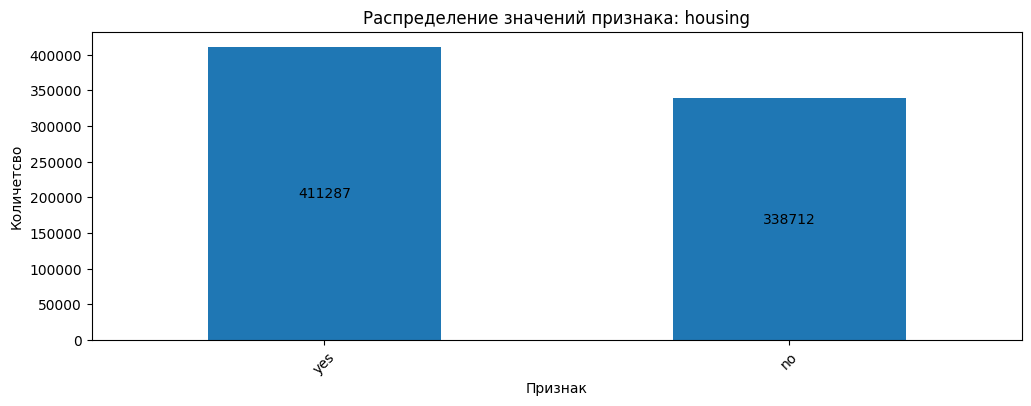

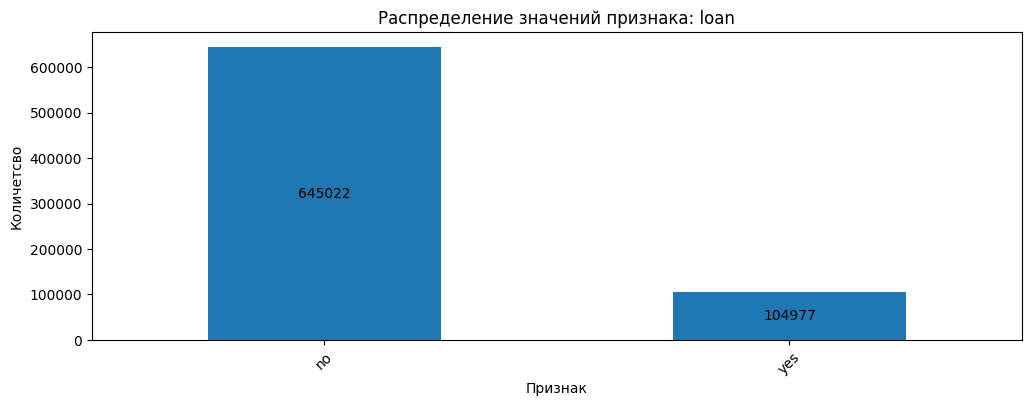

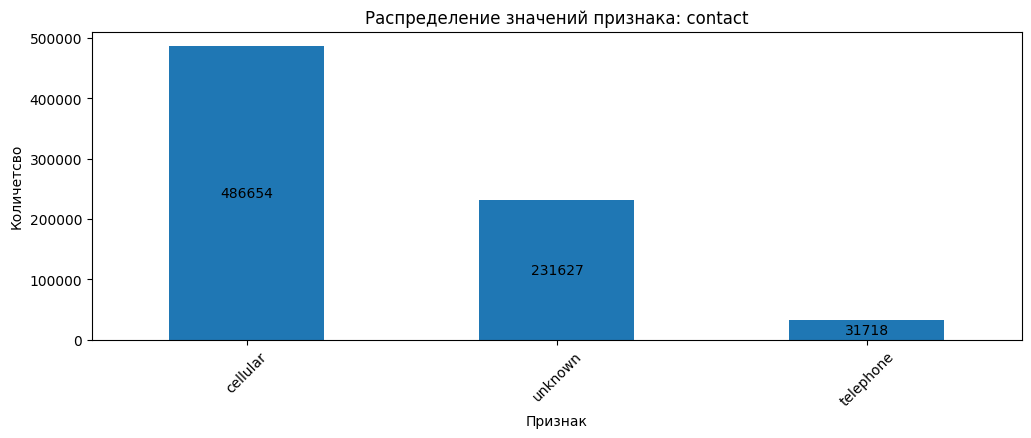

In [26]:
for col in ohe_enc_cats:
    if col in df_eda.columns:
        ax = df_eda[col].value_counts().plot(
            kind='bar',
            title=f'Распределение значений признака: {col}',
            xlabel='Признак',
            ylabel='Количетсво',
            figsize=(12, 4),
            rot=45
        )
        
        ax.bar_label(ax.containers[0], label_type='center')
        
        plt.show()
        plt.close()

In [27]:
def inverse_transform(x):
    return 1 / (x + 1)

In [28]:
heavy_tailed_cols = ['duration']

for col in heavy_tailed_cols:
    df_eda[f'{col}_log'] = np.log1p(df_eda[col])
    df_eda = df_eda.drop(columns=col)

inverse_cols = ['pdays', 'previous']
df_eda[inverse_cols] = df_eda[inverse_cols].clip(0).apply(inverse_transform)

df_eda['is_debtor'] = (df_eda['balance'] < 0).astype(int)
df_eda['balance'] = np.log1p(df_eda['balance'].clip(0))

num_df = df_eda.select_dtypes(include=['number'])
non_binary = num_df.loc[:, ~num_df.isin([0, 1]).all()]

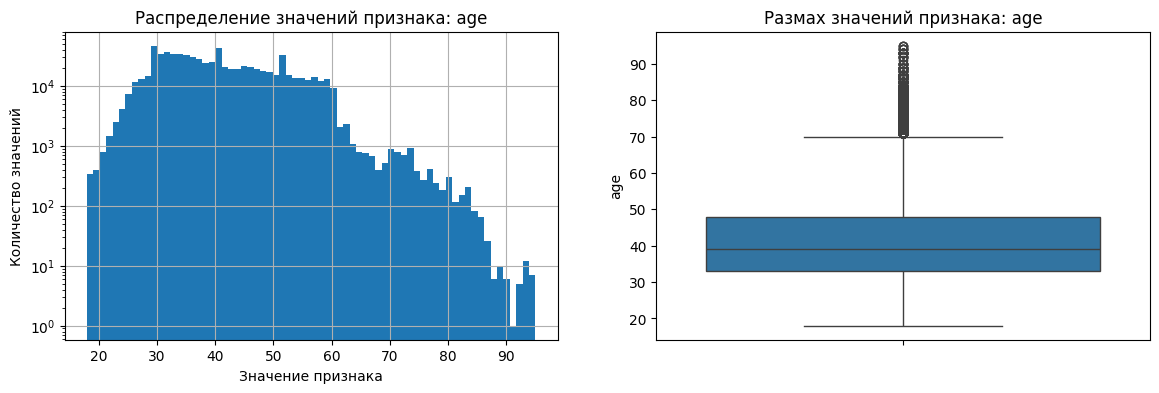

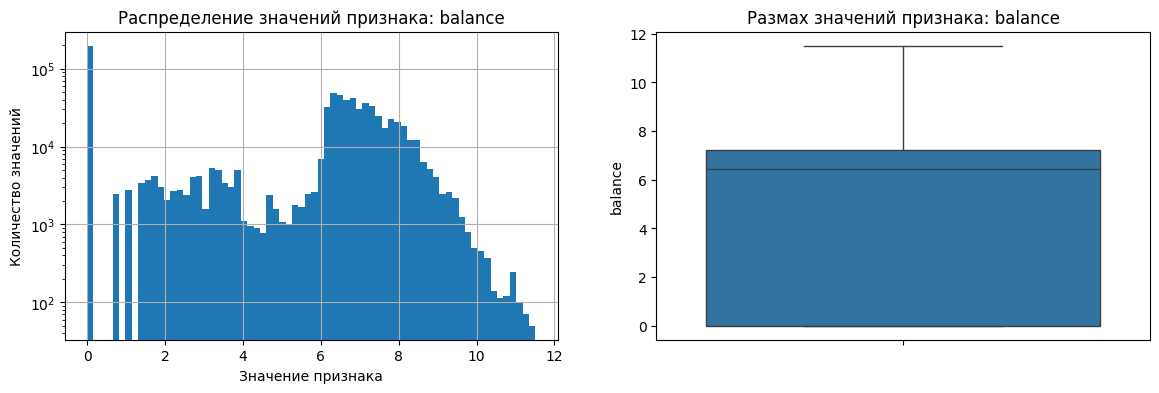

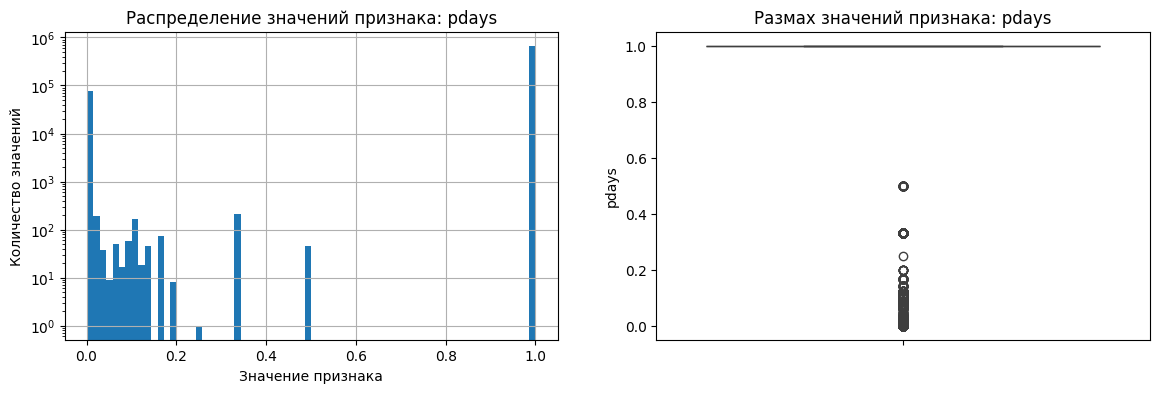

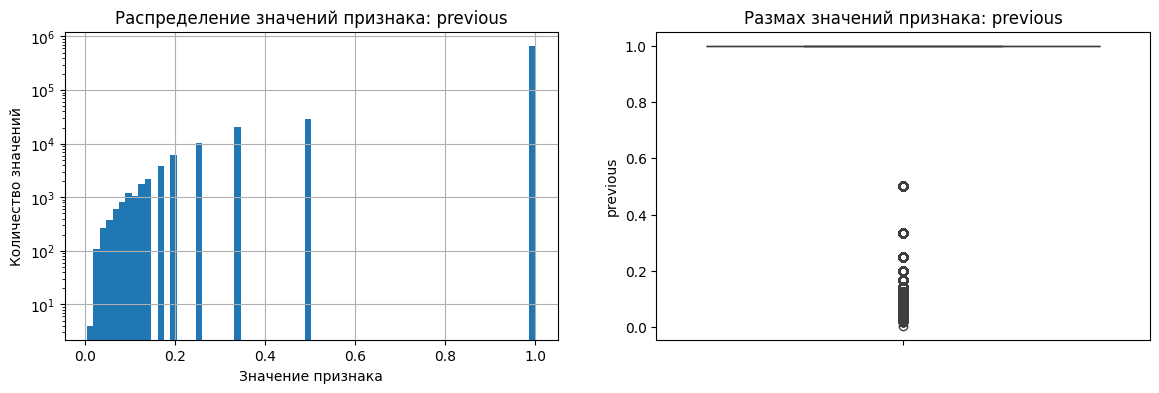

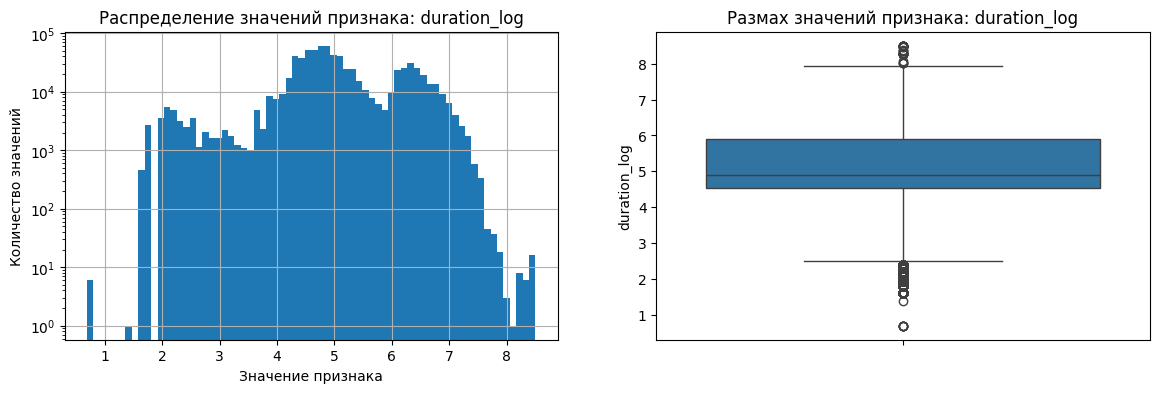

In [29]:
interval_df = get_df_without_discrete(non_binary, discrete)
get_emission_analysis(interval_df)

---

In [30]:
def create_heatmap(corr, ):
    plt.figure(figsize=(6, 5))
    ax = plt.gca()

    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        linewidths=.5,
        cbar=False,
        ax=ax
    )
    
    ax.set_title('Корреляция с целевой переменной')
    
    if len(ax.figure.get_axes()) == 1:
        plt.show()

/Users/katsay/develop/ml/venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


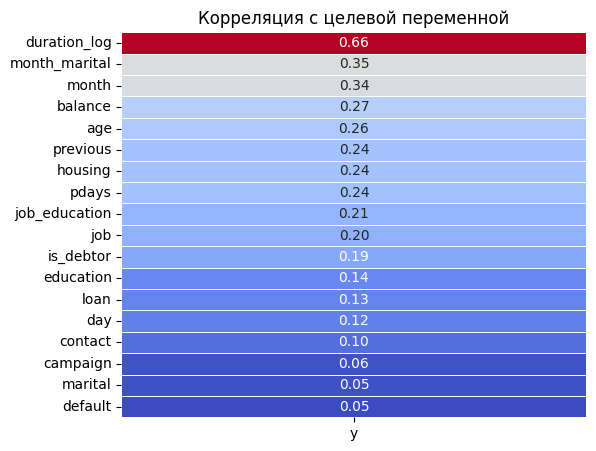

In [31]:
corr_matrix = df_eda.phik_matrix(njobs=4, interval_cols=['balance', 'day', 'campaign', 'pdays', 'previous', 'y', 'age_log', 'duration_log', 'is_debtor'])
target_corr = corr_matrix[corr_matrix.index != target][[target]].sort_values(by=target, ascending=False)

create_heatmap(target_corr)

/Users/katsay/develop/ml/venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


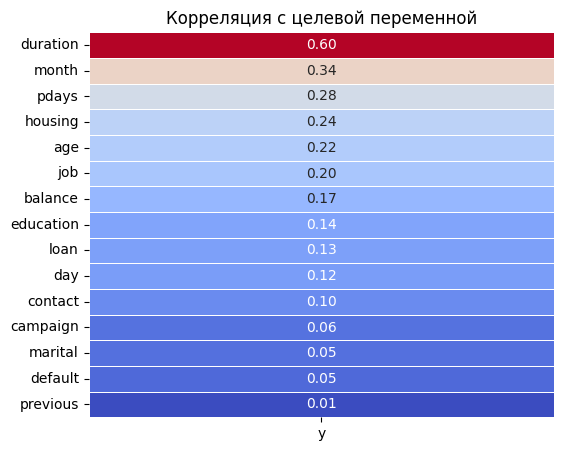

In [32]:
corr_matrix = train.phik_matrix(njobs=4, interval_cols=['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y'])
target_corr = corr_matrix[corr_matrix.index != target][[target]].sort_values(by=target, ascending=False)

create_heatmap(target_corr)

---

In [33]:
X = train.drop(columns=target)
y = train[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=.2,
    stratify=y,
    shuffle=True,
    random_state=RANDOM_STATE
)

print(f"Размер обучающей выборки: {X_train_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Доля положительного класса в train: {y_train_val.mean():.3f}")
print(f"Доля положительного класса в test: {y_test.mean():.3f}")

Размер обучающей выборки: (599999, 15)
Размер тестовой выборки: (150000, 15)
Доля положительного класса в train: 0.121
Доля положительного класса в test: 0.121


In [34]:
def clip_data(X):
    return np.clip(X, 0, None)

def get_debtor_flag(X):
    return (X < 0).astype(int)

def get_log_balance(X):
    return np.log1p(np.maximum(X, 0))

def combine_columns(X):
    X_df = pd.DataFrame(X).fillna('missing').astype(str)
    combined = X_df.iloc[:, 0].str.cat(X_df.iloc[:, 1:], sep='_')
    return combined.values.reshape(-1, 1)

In [35]:
def get_combine_names(_, input_features):
    return [f"{input_features[0][:3]}_{input_features[1][:3]}_combined"]

In [36]:
stand_num_cols = [c for c in nums if c not in ['pdays', 'previous', 'balance', 'duration', 'day']]
transformers = [
    ('num', StandardScaler(), stand_num_cols),

    ('log', make_pipeline(
        FunctionTransformer(np.log1p, feature_names_out='one-to-one'),
        StandardScaler()
    ), ['duration']),
    
    ('inverse', make_pipeline(
        FunctionTransformer(clip_data, feature_names_out='one-to-one'),
        FunctionTransformer(inverse_transform, feature_names_out='one-to-one')
    ), ['previous']),
    
    # ('debtor', FunctionTransformer(get_debtor_flag, feature_names_out='one-to-one'), ['balance']),
    ('balance_scaled', make_pipeline(
        FunctionTransformer(get_log_balance, feature_names_out='one-to-one'),
        StandardScaler()
    ), ['balance']),

    ('target', TargetEncoder(), target_enc_cats),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False), ohe_enc_cats),
]

for col1, col2 in super_matches:
    transformers.append((
        f"{col1}_{col2}", 
        make_pipeline(
            FunctionTransformer(combine_columns, feature_names_out=get_combine_names),
            TargetEncoder()
        ), 
        [col1, col2]
    ))

preprocessor = ColumnTransformer(transformers=transformers).set_output(transform="pandas")

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

In [37]:
X_processed = preprocessor.fit_transform(X_train_val, y_train_val)

X_processed.head()

,num__age,num__campaign,log__duration,inverse__previous,balance_scaled__balance,target__job,target__month,ohe__marital_married,ohe__marital_single,ohe__education_secondary,ohe__education_tertiary,ohe__education_unknown,ohe__default_yes,ohe__housing_yes,ohe__loan_yes,ohe__contact_telephone,ohe__contact_unknown,job_education__job_edu_combined,month_marital__mon_mar_combined
263890,1.690359,0.523659,-0.465946,1.0,-1.496593,0.066730,0.090802,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057158,0.072858
696342,-0.091911,-0.579539,-0.806009,1.0,0.551055,0.081218,0.109704,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069353,0.095206
350451,1.195284,-0.211806,1.132737,1.0,0.755537,0.117475,0.109704,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.111752,0.095206
75362,-0.388956,0.523659,1.269024,1.0,0.683973,0.150443,0.112347,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090972,0.152268
138700,0.799224,-0.579539,2.377939,1.0,0.858715,0.117475,0.235308,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111752,0.202674


In [38]:
def extract_feature_importance(results):
    estimators = results['estimator']
    
    coefs_list = []
    
    for pipe in estimators:
        model = pipe[-1] 

        feature_names = pipe[:-1].get_feature_names_out()
        
        weights = model.coef_[0]
        
        coefs_list.append(pd.Series(weights, index=feature_names))

    df_coefs = pd.DataFrame(coefs_list).mean(axis=0).to_frame(name="importance")
    
    df_coefs['abs_importance'] = df_coefs['importance'].abs()
    
    importance_df = df_coefs.sort_values(by='abs_importance', ascending=False)
    
    print("Топ-5 наиболее влиятельных признаков")
    display(importance_df.head(5))
    
    print("Топ-5 наименее влиятельных признаков")
    display(importance_df.tail(5))

In [39]:
def create_ROC_curve_graph(y_true, y_proba, score, name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (AUC = {score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC-кривая: {name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

In [40]:
def evaluate_model(pipeline, X, y, cv, name="Model"):
    results = cross_validate(
        pipeline, 
        X, 
        y, 
        cv=cv, 
        scoring=["roc_auc"],
        n_jobs=4,
        return_estimator=True,
    )
    score = results["test_roc_auc"].mean()
    
    y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]    
    create_ROC_curve_graph(y, y_proba, score, name)
    
    print(f"[{name}] ROC-AUC: {score:.4f}")

    return extract_feature_importance(results)

In [41]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

/Users/katsay/develop/ml/venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/katsay/develop/ml/venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/katsay/develop/ml/venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


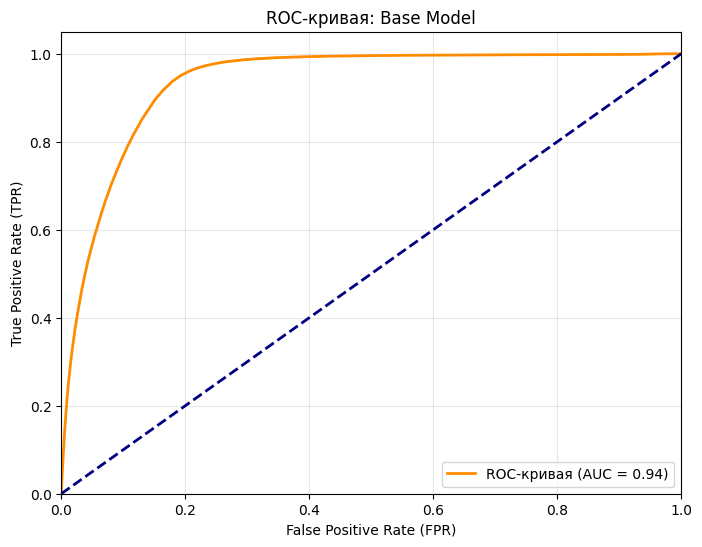

[Base Model] ROC-AUC: 0.9353
Топ-5 наиболее влиятельных признаков


,importance,abs_importance
month_marital__mon_mar_combined,2.512200,2.512200
log__duration,2.142585,2.142585
target__month,2.112890,2.112890
job_education__job_edu_combined,2.035870,2.035870
target__job,1.729920,1.729920


Топ-5 наименее влиятельных признаков


,importance,abs_importance
ohe__contact_telephone,-0.149561,0.149561
ohe__marital_single,0.132080,0.132080
ohe__marital_married,-0.042814,0.042814
ohe__education_unknown,0.032935,0.032935
num__age,-0.025952,0.025952


In [42]:
evaluate_model(pipe, X_train_val, y_train_val, cv, "Base Model")

In [43]:
X_train_val, _, y_train_val, _ = train_test_split(
    X[:10_000],
    y[:10_000],
    test_size=.2,
    stratify=y[:10_000],
    shuffle=True,
    random_state=RANDOM_STATE
)

print(f"Размер обучающей выборки: {X_train_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Доля положительного класса в train: {y_train_val.mean():.3f}")
print(f"Доля положительного класса в test: {y_test.mean():.3f}")

Размер обучающей выборки: (8000, 15)
Размер тестовой выборки: (150000, 15)
Доля положительного класса в train: 0.122
Доля положительного класса в test: 0.121


In [44]:
param_grid = [
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__solver': ['saga'],
        'model__l1_ratio': [0.0, 0.5, 1.0],
        'model__C': [1],
        'model__max_iter': [1800]
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [5, 10],
        'model__min_samples_leaf': [1, 5]
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [500],
        'model__max_depth': [60, 80],
        'model__min_samples_leaf': [2, 4]
    }
]

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=3,
    verbose=1,
    return_train_score=False
)

print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train_val, y_train_val)

Начинаем подбор гиперпараметров...
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/katsay/develop/ml/venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'model': [LogisticRegre...ndom_state=42)], 'model__C': [1], 'model__l1_ratio': [0.0, 0.5, ...], 'model__max_iter': [1800], ...}, {'model': [DecisionTreeC...ndom_state=42)], 'model__max_depth': [5, 10], 'model__min_samples_leaf': [1, 5]}, ...]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",3
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",Stratifi

In [45]:
results_df = pd.DataFrame(grid_search.cv_results_)

results_df['Model'] = results_df['param_model'].apply(lambda x: x.__class__.__name__)

def format_params(params):
    return ", ".join(
        f"{key.replace('model__', '')}={val}" 
        for key, val in params.items() 
        if key != 'model'
    )

results_df['Params'] = results_df['params'].apply(format_params)

columns_to_show = [
    'Model', 
    'Params', 
    'mean_test_score', 
    'std_test_score',
    'rank_test_score'
]

results_table = results_df[columns_to_show].sort_values(by='rank_test_score')
results_table.columns = ['Model', 'Hyperparameters', 'ROC-AUC', 'Std Dev', 'Rank']

print("Топ-10 лучших моделей:")
pd.set_option('display.max_colwidth', None)
results_table.head(10)


Топ-10 лучших моделей:


,Model,Hyperparameters,ROC-AUC,Std Dev,Rank
7,RandomForestClassifier,"max_depth=60, min_samples_leaf=2, n_estimators=500",0.946993,0.009119,1
9,RandomForestClassifier,"max_depth=80, min_samples_leaf=2, n_estimators=500",0.946993,0.009119,1
8,RandomForestClassifier,"max_depth=60, min_samples_leaf=4, n_estimators=500",0.946286,0.009548,3
10,RandomForestClassifier,"max_depth=80, min_samples_leaf=4, n_estimators=500",0.946286,0.009548,3
0,LogisticRegression,"C=1, l1_ratio=0.0, max_iter=1800, solver=saga",0.929743,0.009044,5
1,LogisticRegression,"C=1, l1_ratio=0.5, max_iter=1800, solver=saga",0.929734,0.009122,6
2,LogisticRegression,"C=1, l1_ratio=1.0, max_iter=1800, solver=saga",0.929556,0.009307,7
4,DecisionTreeClassifier,"max_depth=5, min_samples_leaf=5",0.913583,0.010892,8
3,DecisionTreeClassifier,"max_depth=5, min_samples_leaf=1",0.912912,0.011693,9
6,DecisionTreeClassifier,"max_depth=10, min_samples_leaf=5",0.901519,0.013958,10


In [46]:
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший результат валидации (ROC-AUC): {grid_search.best_score_:.4f}")

Лучшие параметры: {'model': RandomForestClassifier(random_state=42), 'model__max_depth': 60, 'model__min_samples_leaf': 2, 'model__n_estimators': 500}
Лучший результат валидации (ROC-AUC): 0.9470


In [47]:
def final_check(best_model, X_test, y_test):
    y_proba = best_model.predict_proba(X_test)[:, 1]

    score = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {score:.4f}")
    
    create_ROC_curve_graph(y_test, y_proba, score, 'Финальная модель')

ROC-AUC: 0.9489


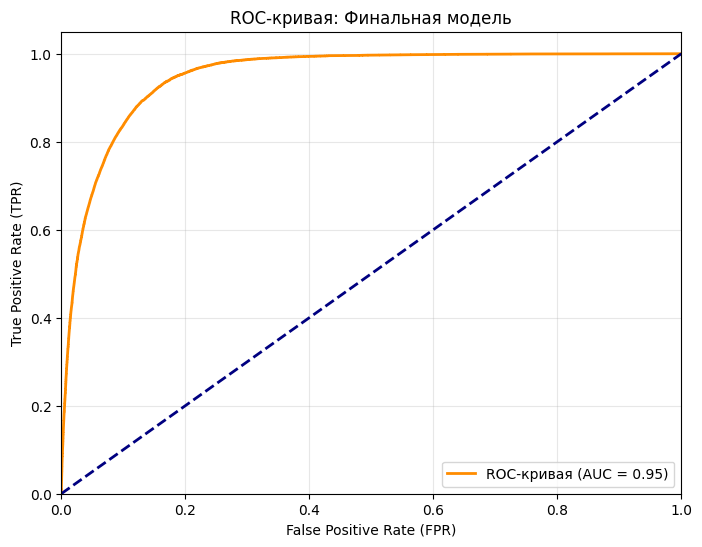

In [48]:
final_check(grid_search.best_estimator_, X_test, y_test)

---

In [49]:
X_test = test.drop(columns=['id'])

y_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'id': test['id'],
    'y': y_proba
})

submission.to_csv('dataset/submissions.csv', index=False)